In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading the dataset with labels

Random Validation Images:


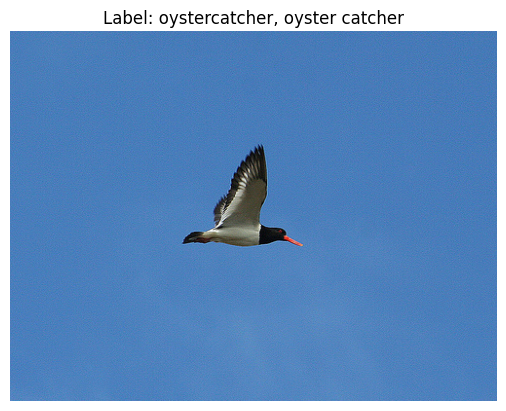

Random Training Images:


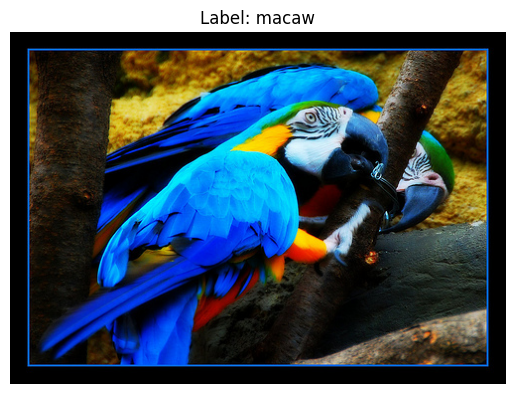

In [16]:
import json
import os
import random
import matplotlib.pyplot as plt
import cv2

# Load labels from JSON file
with open('/kaggle/input/imagenet100/Labels.json', 'r') as f:
    labels = json.load(f)

# Create a mapping from class ID to class name
id_to_class = {str(k): v for k, v in labels.items()}

# Function to display an image with its label
def show_image_with_label(image_path, label):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

# Directories containing the images
base_train_dir = '/kaggle/input/imagenet100'
val_dir = os.path.join(base_train_dir, 'val.X')
train_dirs = [os.path.join(base_train_dir, f'train.X{i}') for i in range(1, 5)]

# Helper function to get a random sample of images from a directory
def get_random_images(data_dirs, num_samples=5):
    images = []
    all_files = []
    for data_dir in data_dirs:
        for label_id in os.listdir(data_dir):
            class_name = id_to_class.get(label_id, 'Unknown')
            files = os.listdir(os.path.join(data_dir, label_id))
            all_files.extend([(os.path.join(data_dir, label_id, filename), class_name) for filename in files])

    selected_files = random.sample(all_files, num_samples)
    for image_path, class_name in selected_files:
        images.append((image_path, class_name))
    return images

# Get random images from validation set
val_images = get_random_images([val_dir], 1)

# Get random images from all training directories
train_images = get_random_images(train_dirs, 1)

# Display random validation images
print("Random Validation Images:")
for image_path, label in val_images:
    show_image_with_label(image_path, label)

# Display random training images
print("Random Training Images:")
for image_path, label in train_images:
    show_image_with_label(image_path, label)

# Setting up Dataset and Dataloaders

In [17]:
# Creating the transforms
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [18]:
# Create a custom dataset class
class MultiFolderDataset(Dataset):
    def __init__(self, folders, transform=None):
        self.samples = []
        self.transform = transform
        for folder in folders:
            for label_id in os.listdir(folder):
                class_name = id_to_class.get(label_id, 'Unknown')
                files = os.listdir(os.path.join(folder, label_id))
                self.samples.extend([(os.path.join(folder, label_id, filename), label_id) for filename in files])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(sorted(id_to_class.keys()))}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        label = self.class_to_idx[label]
        return image, label

In [19]:
import torchvision.datasets as datasets
# Creating the Datasets
train_dataset = MultiFolderDataset(train_dirs, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

In [20]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Setting up the Model

In [21]:
# Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [22]:
!git clone https://github.com/dicarlolab/CORnet.git

Cloning into 'CORnet'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 155 (delta 13), reused 9 (delta 8), pack-reused 135
Receiving objects: 100% (155/155), 68.11 KiB | 1.19 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [23]:
# Navigate to the cloned repository folder
import os
os.chdir('/kaggle/working/CORnet')

# Install the package if needed
!pip install .

Processing /kaggle/working/CORnet
  Preparing metadata (setup.py) ... done
  Created wheel for CORnet: filename=CORnet-0.1.0-py3-none-any.whl size=23228 sha256=acb4c48a66b2a41677dd84793550172a99836f9c6407fd799b7f2d3104acaa60
  Stored in directory: /tmp/pip-ephem-wheel-cache-iop01_v2/wheels/ab/bb/f9/8716bf8cc3f23c0cd07d33b31c64ed0bc87023663d6be90ad5
Successfully built CORnet
  Attempting uninstall: CORnet
    Found existing installation: CORnet 0.1.0
    Uninstalling CORnet-0.1.0:
      Successfully uninstalled CORnet-0.1.0


In [24]:
# Import the CORnet-S model architecture
from cornet import cornet_s

# Initialize the CORnet-S model
model = cornet_s()

In [25]:
# Replace the final layer to match ImageNet100 classes
import torch.nn as nn

num_classes = 100
model.module.decoder.linear = nn.Linear(in_features=model.module.decoder.linear.in_features, out_features=num_classes)

In [26]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
import torch.nn as nn

# Load the pre-trained weights
checkpoint = torch.load("/kaggle/input/cornet-s/pytorch/default/1/cornet_s-1d3f7974.pth", map_location=device)

# Remove the final layer from the checkpoint to avoid size mismatch
del checkpoint['state_dict']['module.decoder.linear.weight']
del checkpoint['state_dict']['module.decoder.linear.bias']

# Load the rest of the weights into the model
model.load_state_dict(checkpoint['state_dict'], strict=False)  # strict=False ignores the missing final layer

_IncompatibleKeys(missing_keys=['module.decoder.linear.weight', 'module.decoder.linear.bias'], unexpected_keys=[])

In [32]:
import tqdm

# Function to evaluate model performance (pre-training and post-training)
def evaluate_model(model, loader):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct1 = 0
    correct5 = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(loader, desc="Evaluating"):  # Corrected tqdm usage
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            val_loss += loss.item() * inputs.size(0)  # Update validation loss

            # Calculate top-1 and top-5 accuracy
            _, pred1 = outputs.topk(1, 1, True, True)
            _, pred5 = outputs.topk(5, 1, True, True)
            correct1 += pred1.eq(labels.view(-1, 1).expand_as(pred1)).sum().item()
            correct5 += pred5.eq(labels.view(-1, 1).expand_as(pred5)).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(loader.dataset)  # Compute validation loss
    top1_acc = correct1 / total  # Compute top-1 accuracy
    top5_acc = correct5 / total  # Compute top-5 accuracy

    print(f'Validation Loss: {epoch_val_loss:.4f}')
    print(f'Top-1 Accuracy: {top1_acc:.4f}, Top-5 Accuracy: {top5_acc:.4f}')
    
    return top1_acc, top5_acc

# Initial evaluation of pre-trained model
print("Evaluating pre-trained model before fine-tuning:")
evaluate_model(model, val_loader)

Evaluating pre-trained model before fine-tuning:


Evaluating: 100%|██████████| 157/157 [01:25<00:00,  1.84it/s]

Validation Loss: 4.8462
Top-1 Accuracy: 0.0124, Top-5 Accuracy: 0.0556


(0.0124, 0.0556)

In [33]:
# Ensure CUDA is available
print(f"CUDA available: {torch.cuda.is_available()}")

# Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Import necessary modules
import time
from tqdm import tqdm

# Move model to the appropriate device
model = model.to(device)

# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Training phase
    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}")):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item() * inputs.size(0)  # Update running loss

        if i % 100 == 0:  # Print every 100 batches
            print(f"Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader.dataset)  # Compute epoch loss

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct1 = 0
    correct5 = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            val_loss += loss.item() * inputs.size(0)  # Update validation loss

            # Calculate top-1 and top-5 accuracy
            _, pred1 = outputs.topk(1, 1, True, True)
            _, pred5 = outputs.topk(5, 1, True, True)
            correct1 += pred1.eq(labels.view(-1, 1).expand_as(pred1)).sum().item()
            correct5 += pred5.eq(labels.view(-1, 1).expand_as(pred5)).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(val_loader.dataset)  # Compute epoch validation loss
    top1_acc = correct1 / total  # Compute top-1 accuracy
    top5_acc = correct5 / total  # Compute top-5 accuracy

    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f'Epoch [{epoch+1}/{num_epochs}] - Time: {epoch_duration:.2f}s')
    print(f'Train Loss: {epoch_loss:.4f}')
    print(f'Validation Loss: {epoch_val_loss:.4f}')
    print(f'Top-1 Accuracy: {top1_acc:.4f}, Top-5 Accuracy: {top5_acc:.4f}')

    # Save the model checkpoint
    model_save_path = f'/kaggle/working/cornet_s_epoch{epoch+1}.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f'Model saved at {model_save_path}')

print('Training complete')

CUDA available: True
Using device: cuda


Training Epoch 1/5:   0%|          | 1/4063 [00:01<1:22:43,  1.22s/it]

Step [0/4063], Loss: 4.8520


Training Epoch 1/5:   2%|▏         | 101/4063 [01:26<55:32,  1.19it/s] 

Step [100/4063], Loss: 4.4666


Training Epoch 1/5:   5%|▍         | 201/4063 [02:50<53:58,  1.19it/s]

Step [200/4063], Loss: 4.4229


Training Epoch 1/5:   7%|▋         | 301/4063 [04:14<53:27,  1.17it/s]

Step [300/4063], Loss: 3.8947


Training Epoch 1/5:  10%|▉         | 401/4063 [05:39<52:26,  1.16it/s]

Step [400/4063], Loss: 4.1091


Training Epoch 1/5:  12%|█▏        | 501/4063 [07:04<50:39,  1.17it/s]

Step [500/4063], Loss: 4.0610


Training Epoch 1/5:  15%|█▍        | 601/4063 [08:30<48:27,  1.19it/s]

Step [600/4063], Loss: 3.5182


Training Epoch 1/5:  17%|█▋        | 701/4063 [09:56<48:55,  1.15it/s]

Step [700/4063], Loss: 3.4631


Training Epoch 1/5:  20%|█▉        | 801/4063 [11:21<47:09,  1.15it/s]

Step [800/4063], Loss: 3.7535


Training Epoch 1/5:  22%|██▏       | 901/4063 [12:47<44:06,  1.19it/s]

Step [900/4063], Loss: 3.5366


Training Epoch 1/5:  25%|██▍       | 1001/4063 [14:13<44:02,  1.16it/s]

Step [1000/4063], Loss: 3.8502


Training Epoch 1/5:  27%|██▋       | 1101/4063 [15:40<42:24,  1.16it/s]

Step [1100/4063], Loss: 3.9092


Training Epoch 1/5:  30%|██▉       | 1201/4063 [17:06<41:40,  1.14it/s]

Step [1200/4063], Loss: 3.0583


Training Epoch 1/5:  32%|███▏      | 1301/4063 [18:33<39:32,  1.16it/s]

Step [1300/4063], Loss: 3.2480


Training Epoch 1/5:  34%|███▍      | 1401/4063 [20:00<37:49,  1.17it/s]

Step [1400/4063], Loss: 3.0479


Training Epoch 1/5:  37%|███▋      | 1501/4063 [21:27<37:14,  1.15it/s]

Step [1500/4063], Loss: 3.1618


Training Epoch 1/5:  39%|███▉      | 1601/4063 [22:54<35:47,  1.15it/s]

Step [1600/4063], Loss: 3.0222


Training Epoch 1/5:  42%|████▏     | 1701/4063 [24:21<33:58,  1.16it/s]

Step [1700/4063], Loss: 2.9052


Training Epoch 1/5:  44%|████▍     | 1801/4063 [25:47<32:45,  1.15it/s]

Step [1800/4063], Loss: 2.9357


Training Epoch 1/5:  47%|████▋     | 1901/4063 [27:14<32:21,  1.11it/s]

Step [1900/4063], Loss: 3.0306


Training Epoch 1/5:  49%|████▉     | 2001/4063 [28:40<30:23,  1.13it/s]

Step [2000/4063], Loss: 2.6390


Training Epoch 1/5:  52%|█████▏    | 2101/4063 [30:07<28:20,  1.15it/s]

Step [2100/4063], Loss: 2.5448


Training Epoch 1/5:  54%|█████▍    | 2201/4063 [31:34<27:17,  1.14it/s]

Step [2200/4063], Loss: 2.9863


Training Epoch 1/5:  57%|█████▋    | 2301/4063 [33:00<24:47,  1.18it/s]

Step [2300/4063], Loss: 2.9865


Training Epoch 1/5:  59%|█████▉    | 2401/4063 [34:28<23:55,  1.16it/s]

Step [2400/4063], Loss: 3.1333


Training Epoch 1/5:  62%|██████▏   | 2501/4063 [35:54<23:12,  1.12it/s]

Step [2500/4063], Loss: 2.3853


Training Epoch 1/5:  64%|██████▍   | 2601/4063 [37:21<21:07,  1.15it/s]

Step [2600/4063], Loss: 2.5368


Training Epoch 1/5:  66%|██████▋   | 2701/4063 [38:48<19:26,  1.17it/s]

Step [2700/4063], Loss: 2.4189


Training Epoch 1/5:  69%|██████▉   | 2801/4063 [40:15<17:54,  1.17it/s]

Step [2800/4063], Loss: 2.6065


Training Epoch 1/5:  71%|███████▏  | 2901/4063 [41:42<16:39,  1.16it/s]

Step [2900/4063], Loss: 2.4686


Training Epoch 1/5:  74%|███████▍  | 3001/4063 [43:09<16:02,  1.10it/s]

Step [3000/4063], Loss: 2.4151


Training Epoch 1/5:  76%|███████▋  | 3101/4063 [44:37<13:35,  1.18it/s]

Step [3100/4063], Loss: 3.1676


Training Epoch 1/5:  79%|███████▉  | 3201/4063 [46:03<12:13,  1.17it/s]

Step [3200/4063], Loss: 2.3002


Training Epoch 1/5:  81%|████████  | 3301/4063 [47:30<11:11,  1.13it/s]

Step [3300/4063], Loss: 2.1570


Training Epoch 1/5:  84%|████████▎ | 3401/4063 [48:56<09:33,  1.15it/s]

Step [3400/4063], Loss: 2.0871


Training Epoch 1/5:  86%|████████▌ | 3501/4063 [50:25<08:08,  1.15it/s]

Step [3500/4063], Loss: 2.9445


Training Epoch 1/5:  89%|████████▊ | 3601/4063 [51:51<06:27,  1.19it/s]

Step [3600/4063], Loss: 2.1702


Training Epoch 1/5:  91%|█████████ | 3701/4063 [53:17<05:17,  1.14it/s]

Step [3700/4063], Loss: 3.1702


Training Epoch 1/5:  94%|█████████▎| 3801/4063 [54:44<03:38,  1.20it/s]

Step [3800/4063], Loss: 2.3712


Training Epoch 1/5:  96%|█████████▌| 3901/4063 [56:11<02:22,  1.14it/s]

Step [3900/4063], Loss: 2.2648


Training Epoch 1/5:  98%|█████████▊| 4001/4063 [57:38<00:53,  1.16it/s]

Step [4000/4063], Loss: 2.7200


Validation Epoch 1/5: 100%|██████████| 157/157 [00:57<00:00,  2.72it/s]


Epoch [1/5] - Time: 3569.89s
Train Loss: 3.0577
Validation Loss: 2.4745
Top-1 Accuracy: 0.3514, Top-5 Accuracy: 0.6834
Model saved at /kaggle/working/cornet_s_epoch1.pth


Training Epoch 2/5:   0%|          | 1/4063 [00:00<44:15,  1.53it/s]

Step [0/4063], Loss: 1.7099


Training Epoch 2/5:   2%|▏         | 101/4063 [01:06<43:05,  1.53it/s]

Step [100/4063], Loss: 1.9828


Training Epoch 2/5:   5%|▍         | 201/4063 [02:11<41:11,  1.56it/s]

Step [200/4063], Loss: 2.3500


Training Epoch 2/5:   7%|▋         | 301/4063 [03:17<41:12,  1.52it/s]

Step [300/4063], Loss: 1.5947


Training Epoch 2/5:  10%|▉         | 401/4063 [04:23<40:39,  1.50it/s]

Step [400/4063], Loss: 2.1859


Training Epoch 2/5:  12%|█▏        | 501/4063 [05:29<39:21,  1.51it/s]

Step [500/4063], Loss: 2.5009


Training Epoch 2/5:  15%|█▍        | 601/4063 [06:34<37:29,  1.54it/s]

Step [600/4063], Loss: 2.2823


Training Epoch 2/5:  17%|█▋        | 701/4063 [07:41<38:32,  1.45it/s]

Step [700/4063], Loss: 1.8488


Training Epoch 2/5:  20%|█▉        | 801/4063 [08:47<35:58,  1.51it/s]

Step [800/4063], Loss: 2.3390


Training Epoch 2/5:  22%|██▏       | 901/4063 [09:53<34:37,  1.52it/s]

Step [900/4063], Loss: 2.0725


Training Epoch 2/5:  25%|██▍       | 1001/4063 [10:59<32:43,  1.56it/s]

Step [1000/4063], Loss: 2.1152


Training Epoch 2/5:  27%|██▋       | 1101/4063 [12:05<31:53,  1.55it/s]

Step [1100/4063], Loss: 1.8190


Training Epoch 2/5:  30%|██▉       | 1201/4063 [13:11<32:36,  1.46it/s]

Step [1200/4063], Loss: 2.2770


Training Epoch 2/5:  32%|███▏      | 1301/4063 [14:17<29:42,  1.55it/s]

Step [1300/4063], Loss: 2.4086


Training Epoch 2/5:  34%|███▍      | 1401/4063 [15:23<29:07,  1.52it/s]

Step [1400/4063], Loss: 2.4039


Training Epoch 2/5:  37%|███▋      | 1501/4063 [16:28<28:07,  1.52it/s]

Step [1500/4063], Loss: 1.7295


Training Epoch 2/5:  39%|███▉      | 1601/4063 [17:34<26:18,  1.56it/s]

Step [1600/4063], Loss: 2.2274


Training Epoch 2/5:  42%|████▏     | 1701/4063 [18:41<26:04,  1.51it/s]

Step [1700/4063], Loss: 2.6699


Training Epoch 2/5:  44%|████▍     | 1801/4063 [19:47<24:33,  1.54it/s]

Step [1800/4063], Loss: 2.0785


Training Epoch 2/5:  47%|████▋     | 1901/4063 [20:54<23:37,  1.53it/s]

Step [1900/4063], Loss: 2.3243


Training Epoch 2/5:  49%|████▉     | 2001/4063 [22:00<22:52,  1.50it/s]

Step [2000/4063], Loss: 2.6297


Training Epoch 2/5:  52%|█████▏    | 2101/4063 [23:07<21:29,  1.52it/s]

Step [2100/4063], Loss: 1.9781


Training Epoch 2/5:  54%|█████▍    | 2201/4063 [24:12<20:19,  1.53it/s]

Step [2200/4063], Loss: 1.9869


Training Epoch 2/5:  57%|█████▋    | 2301/4063 [25:19<19:11,  1.53it/s]

Step [2300/4063], Loss: 1.7810


Training Epoch 2/5:  59%|█████▉    | 2401/4063 [26:26<18:12,  1.52it/s]

Step [2400/4063], Loss: 1.6840


Training Epoch 2/5:  62%|██████▏   | 2501/4063 [27:32<17:17,  1.51it/s]

Step [2500/4063], Loss: 2.1150


Training Epoch 2/5:  64%|██████▍   | 2601/4063 [28:38<16:44,  1.46it/s]

Step [2600/4063], Loss: 1.6348


Training Epoch 2/5:  66%|██████▋   | 2701/4063 [29:44<14:48,  1.53it/s]

Step [2700/4063], Loss: 1.9518


Training Epoch 2/5:  69%|██████▉   | 2801/4063 [30:50<14:05,  1.49it/s]

Step [2800/4063], Loss: 1.9257


Training Epoch 2/5:  71%|███████▏  | 2901/4063 [31:58<13:16,  1.46it/s]

Step [2900/4063], Loss: 1.8020


Training Epoch 2/5:  74%|███████▍  | 3001/4063 [33:05<11:46,  1.50it/s]

Step [3000/4063], Loss: 1.7264


Training Epoch 2/5:  76%|███████▋  | 3101/4063 [34:12<11:15,  1.42it/s]

Step [3100/4063], Loss: 1.4575


Training Epoch 2/5:  79%|███████▉  | 3201/4063 [35:19<09:27,  1.52it/s]

Step [3200/4063], Loss: 2.1220


Training Epoch 2/5:  81%|████████  | 3301/4063 [36:25<08:23,  1.51it/s]

Step [3300/4063], Loss: 2.3212


Training Epoch 2/5:  84%|████████▎ | 3401/4063 [37:32<07:11,  1.53it/s]

Step [3400/4063], Loss: 1.7432


Training Epoch 2/5:  86%|████████▌ | 3501/4063 [38:39<06:09,  1.52it/s]

Step [3500/4063], Loss: 1.6924


Training Epoch 2/5:  89%|████████▊ | 3601/4063 [39:46<05:17,  1.46it/s]

Step [3600/4063], Loss: 1.5763


Training Epoch 2/5:  91%|█████████ | 3701/4063 [40:52<03:58,  1.52it/s]

Step [3700/4063], Loss: 1.9205


Training Epoch 2/5:  94%|█████████▎| 3801/4063 [41:59<02:54,  1.50it/s]

Step [3800/4063], Loss: 1.5924


Training Epoch 2/5:  96%|█████████▌| 3901/4063 [43:05<01:49,  1.48it/s]

Step [3900/4063], Loss: 1.4496


Training Epoch 2/5:  98%|█████████▊| 4001/4063 [44:12<00:41,  1.49it/s]

Step [4000/4063], Loss: 2.0391


Validation Epoch 2/5: 100%|██████████| 157/157 [00:57<00:00,  2.73it/s]


Epoch [2/5] - Time: 2750.97s
Train Loss: 2.0334
Validation Loss: 1.9464
Top-1 Accuracy: 0.4848, Top-5 Accuracy: 0.7832
Model saved at /kaggle/working/cornet_s_epoch2.pth


Training Epoch 3/5:   0%|          | 1/4063 [00:00<46:17,  1.46it/s]

Step [0/4063], Loss: 1.8206


Training Epoch 3/5:   2%|▏         | 101/4063 [01:05<41:34,  1.59it/s]

Step [100/4063], Loss: 1.7466


Training Epoch 3/5:   5%|▍         | 201/4063 [02:10<40:47,  1.58it/s]

Step [200/4063], Loss: 1.0443


Training Epoch 3/5:   7%|▋         | 301/4063 [03:16<44:14,  1.42it/s]

Step [300/4063], Loss: 1.5358


Training Epoch 3/5:  10%|▉         | 401/4063 [04:21<39:51,  1.53it/s]

Step [400/4063], Loss: 2.1802


Training Epoch 3/5:  12%|█▏        | 501/4063 [05:27<37:34,  1.58it/s]

Step [500/4063], Loss: 1.8913


Training Epoch 3/5:  15%|█▍        | 601/4063 [06:32<37:40,  1.53it/s]

Step [600/4063], Loss: 1.6140


Training Epoch 3/5:  17%|█▋        | 701/4063 [07:37<36:01,  1.56it/s]

Step [700/4063], Loss: 1.5038


Training Epoch 3/5:  20%|█▉        | 801/4063 [08:42<35:05,  1.55it/s]

Step [800/4063], Loss: 1.5475


Training Epoch 3/5:  22%|██▏       | 901/4063 [09:48<34:25,  1.53it/s]

Step [900/4063], Loss: 2.0456


Training Epoch 3/5:  25%|██▍       | 1001/4063 [10:53<33:49,  1.51it/s]

Step [1000/4063], Loss: 1.8308


Training Epoch 3/5:  27%|██▋       | 1101/4063 [12:00<32:32,  1.52it/s]

Step [1100/4063], Loss: 1.8635


Training Epoch 3/5:  30%|██▉       | 1201/4063 [13:06<31:11,  1.53it/s]

Step [1200/4063], Loss: 1.4180


Training Epoch 3/5:  32%|███▏      | 1301/4063 [14:12<31:42,  1.45it/s]

Step [1300/4063], Loss: 1.7788


Training Epoch 3/5:  34%|███▍      | 1401/4063 [15:18<28:46,  1.54it/s]

Step [1400/4063], Loss: 1.9688


Training Epoch 3/5:  37%|███▋      | 1501/4063 [16:24<27:49,  1.53it/s]

Step [1500/4063], Loss: 1.6905


Training Epoch 3/5:  39%|███▉      | 1601/4063 [17:30<26:43,  1.54it/s]

Step [1600/4063], Loss: 1.5950


Training Epoch 3/5:  42%|████▏     | 1701/4063 [18:37<25:46,  1.53it/s]

Step [1700/4063], Loss: 2.2336


Training Epoch 3/5:  44%|████▍     | 1801/4063 [19:44<24:53,  1.51it/s]

Step [1800/4063], Loss: 2.2426


Training Epoch 3/5:  47%|████▋     | 1901/4063 [20:50<23:40,  1.52it/s]

Step [1900/4063], Loss: 1.7530


Training Epoch 3/5:  49%|████▉     | 2001/4063 [21:56<23:17,  1.48it/s]

Step [2000/4063], Loss: 1.7800


Training Epoch 3/5:  52%|█████▏    | 2101/4063 [23:03<21:29,  1.52it/s]

Step [2100/4063], Loss: 1.8752


Training Epoch 3/5:  54%|█████▍    | 2201/4063 [24:09<20:55,  1.48it/s]

Step [2200/4063], Loss: 1.3307


Training Epoch 3/5:  57%|█████▋    | 2301/4063 [25:15<19:03,  1.54it/s]

Step [2300/4063], Loss: 1.5489


Training Epoch 3/5:  59%|█████▉    | 2401/4063 [26:22<18:00,  1.54it/s]

Step [2400/4063], Loss: 1.3408


Training Epoch 3/5:  62%|██████▏   | 2501/4063 [27:29<17:16,  1.51it/s]

Step [2500/4063], Loss: 1.3022


Training Epoch 3/5:  64%|██████▍   | 2601/4063 [28:35<15:48,  1.54it/s]

Step [2600/4063], Loss: 1.6098


Training Epoch 3/5:  66%|██████▋   | 2701/4063 [29:41<15:06,  1.50it/s]

Step [2700/4063], Loss: 1.7379


Training Epoch 3/5:  69%|██████▉   | 2801/4063 [30:48<14:04,  1.49it/s]

Step [2800/4063], Loss: 1.7467


Training Epoch 3/5:  71%|███████▏  | 2901/4063 [31:55<12:48,  1.51it/s]

Step [2900/4063], Loss: 1.8404


Training Epoch 3/5:  74%|███████▍  | 3001/4063 [33:01<11:34,  1.53it/s]

Step [3000/4063], Loss: 1.2734


Training Epoch 3/5:  76%|███████▋  | 3101/4063 [34:07<10:47,  1.49it/s]

Step [3100/4063], Loss: 1.5233


Training Epoch 3/5:  79%|███████▉  | 3201/4063 [35:14<09:21,  1.54it/s]

Step [3200/4063], Loss: 1.5090


Training Epoch 3/5:  81%|████████  | 3301/4063 [36:20<08:15,  1.54it/s]

Step [3300/4063], Loss: 2.0370


Training Epoch 3/5:  84%|████████▎ | 3401/4063 [37:26<07:07,  1.55it/s]

Step [3400/4063], Loss: 1.2004


Training Epoch 3/5:  86%|████████▌ | 3501/4063 [38:33<06:14,  1.50it/s]

Step [3500/4063], Loss: 1.6305


Training Epoch 3/5:  89%|████████▊ | 3601/4063 [39:40<05:07,  1.50it/s]

Step [3600/4063], Loss: 1.4717


Training Epoch 3/5:  91%|█████████ | 3701/4063 [40:46<03:54,  1.54it/s]

Step [3700/4063], Loss: 1.9741


Training Epoch 3/5:  94%|█████████▎| 3801/4063 [41:53<02:51,  1.53it/s]

Step [3800/4063], Loss: 1.7327


Training Epoch 3/5:  96%|█████████▌| 3901/4063 [42:59<01:47,  1.51it/s]

Step [3900/4063], Loss: 1.9473


Training Epoch 3/5:  98%|█████████▊| 4001/4063 [44:05<00:41,  1.49it/s]

Step [4000/4063], Loss: 1.5710


Validation Epoch 3/5: 100%|██████████| 157/157 [00:57<00:00,  2.71it/s]


Epoch [3/5] - Time: 2743.83s
Train Loss: 1.6312
Validation Loss: 1.6250
Top-1 Accuracy: 0.5632, Top-5 Accuracy: 0.8352
Model saved at /kaggle/working/cornet_s_epoch3.pth


Training Epoch 4/5:   0%|          | 1/4063 [00:00<45:58,  1.47it/s]

Step [0/4063], Loss: 1.1457


Training Epoch 4/5:   2%|▏         | 101/4063 [01:06<43:02,  1.53it/s]

Step [100/4063], Loss: 1.2839


Training Epoch 4/5:   5%|▍         | 201/4063 [02:12<43:55,  1.47it/s]

Step [200/4063], Loss: 1.2231


Training Epoch 4/5:   7%|▋         | 301/4063 [03:18<41:21,  1.52it/s]

Step [300/4063], Loss: 1.5093


Training Epoch 4/5:  10%|▉         | 401/4063 [04:23<39:28,  1.55it/s]

Step [400/4063], Loss: 1.6267


Training Epoch 4/5:  12%|█▏        | 501/4063 [05:29<39:00,  1.52it/s]

Step [500/4063], Loss: 1.3117


Training Epoch 4/5:  15%|█▍        | 601/4063 [06:35<37:30,  1.54it/s]

Step [600/4063], Loss: 1.4946


Training Epoch 4/5:  17%|█▋        | 701/4063 [07:40<36:09,  1.55it/s]

Step [700/4063], Loss: 1.5488


Training Epoch 4/5:  20%|█▉        | 801/4063 [08:45<34:23,  1.58it/s]

Step [800/4063], Loss: 1.8848


Training Epoch 4/5:  22%|██▏       | 901/4063 [09:51<35:09,  1.50it/s]

Step [900/4063], Loss: 2.0208


Training Epoch 4/5:  25%|██▍       | 1001/4063 [10:57<33:09,  1.54it/s]

Step [1000/4063], Loss: 1.1782


Training Epoch 4/5:  27%|██▋       | 1101/4063 [12:03<33:27,  1.48it/s]

Step [1100/4063], Loss: 1.4718


Training Epoch 4/5:  30%|██▉       | 1201/4063 [13:10<37:33,  1.27it/s]

Step [1200/4063], Loss: 1.0771


Training Epoch 4/5:  32%|███▏      | 1301/4063 [14:16<32:36,  1.41it/s]

Step [1300/4063], Loss: 1.6289


Training Epoch 4/5:  39%|███▉      | 1601/4063 [17:34<26:52,  1.53it/s]

Step [1600/4063], Loss: 1.2374


Training Epoch 4/5:  42%|████▏     | 1701/4063 [18:40<25:53,  1.52it/s]

Step [1700/4063], Loss: 1.9498


Training Epoch 4/5:  44%|████▍     | 1801/4063 [19:47<25:59,  1.45it/s]

Step [1800/4063], Loss: 1.7175


Training Epoch 4/5:  47%|████▋     | 1901/4063 [20:53<23:18,  1.55it/s]

Step [1900/4063], Loss: 1.7510


Training Epoch 4/5:  49%|████▉     | 2001/4063 [21:58<22:33,  1.52it/s]

Step [2000/4063], Loss: 1.2989


Training Epoch 4/5:  52%|█████▏    | 2101/4063 [23:04<21:31,  1.52it/s]

Step [2100/4063], Loss: 1.5725


Training Epoch 4/5:  54%|█████▍    | 2201/4063 [24:10<20:41,  1.50it/s]

Step [2200/4063], Loss: 0.8015


Training Epoch 4/5:  57%|█████▋    | 2301/4063 [25:16<18:58,  1.55it/s]

Step [2300/4063], Loss: 1.4290


Training Epoch 4/5:  59%|█████▉    | 2401/4063 [26:21<17:46,  1.56it/s]

Step [2400/4063], Loss: 1.4027


Training Epoch 4/5:  62%|██████▏   | 2501/4063 [27:27<16:52,  1.54it/s]

Step [2500/4063], Loss: 1.3725


Training Epoch 4/5:  64%|██████▍   | 2601/4063 [28:33<15:53,  1.53it/s]

Step [2600/4063], Loss: 1.1806


Training Epoch 4/5:  66%|██████▋   | 2701/4063 [29:39<14:33,  1.56it/s]

Step [2700/4063], Loss: 1.1280


Training Epoch 4/5:  69%|██████▉   | 2801/4063 [30:46<14:02,  1.50it/s]

Step [2800/4063], Loss: 1.1896


Training Epoch 4/5:  71%|███████▏  | 2901/4063 [31:54<12:59,  1.49it/s]

Step [2900/4063], Loss: 1.1671


Training Epoch 4/5:  74%|███████▍  | 3001/4063 [33:01<11:49,  1.50it/s]

Step [3000/4063], Loss: 1.3543


Training Epoch 4/5:  76%|███████▋  | 3101/4063 [34:09<11:16,  1.42it/s]

Step [3100/4063], Loss: 1.5514


Training Epoch 4/5:  79%|███████▉  | 3201/4063 [35:17<09:42,  1.48it/s]

Step [3200/4063], Loss: 1.1735


Training Epoch 4/5:  81%|████████  | 3301/4063 [36:24<08:25,  1.51it/s]

Step [3300/4063], Loss: 1.6568


Training Epoch 4/5:  84%|████████▎ | 3401/4063 [37:31<07:13,  1.53it/s]

Step [3400/4063], Loss: 1.3178


Training Epoch 4/5:  86%|████████▌ | 3501/4063 [38:39<06:11,  1.51it/s]

Step [3500/4063], Loss: 1.7182


Training Epoch 4/5:  89%|████████▊ | 3601/4063 [39:46<05:07,  1.50it/s]

Step [3600/4063], Loss: 1.6204


Training Epoch 4/5:  91%|█████████ | 3701/4063 [40:53<04:03,  1.49it/s]

Step [3700/4063], Loss: 2.0012


Training Epoch 4/5:  94%|█████████▎| 3801/4063 [42:00<02:58,  1.46it/s]

Step [3800/4063], Loss: 1.2438


Training Epoch 4/5:  96%|█████████▌| 3901/4063 [43:07<01:46,  1.52it/s]

Step [3900/4063], Loss: 0.8244


Training Epoch 4/5:  98%|█████████▊| 4001/4063 [44:13<00:40,  1.54it/s]

Step [4000/4063], Loss: 1.0405


Validation Epoch 4/5: 100%|██████████| 157/157 [00:58<00:00,  2.71it/s]


Epoch [4/5] - Time: 2752.72s
Train Loss: 1.3973
Validation Loss: 1.4536
Top-1 Accuracy: 0.6062, Top-5 Accuracy: 0.8634
Model saved at /kaggle/working/cornet_s_epoch4.pth


Training Epoch 5/5:   0%|          | 1/4063 [00:00<49:11,  1.38it/s]

Step [0/4063], Loss: 1.3961


Training Epoch 5/5:   2%|▏         | 101/4063 [01:06<42:50,  1.54it/s]

Step [100/4063], Loss: 1.1196


Training Epoch 5/5:   5%|▍         | 201/4063 [02:11<41:30,  1.55it/s]

Step [200/4063], Loss: 1.2024


Training Epoch 5/5:   7%|▋         | 301/4063 [03:17<41:04,  1.53it/s]

Step [300/4063], Loss: 1.4495


Training Epoch 5/5:  10%|▉         | 401/4063 [04:22<41:09,  1.48it/s]

Step [400/4063], Loss: 0.9219


Training Epoch 5/5:  12%|█▏        | 501/4063 [05:27<38:58,  1.52it/s]

Step [500/4063], Loss: 1.5112


Training Epoch 5/5:  15%|█▍        | 601/4063 [06:33<36:55,  1.56it/s]

Step [600/4063], Loss: 0.8858


Training Epoch 5/5:  17%|█▋        | 701/4063 [07:38<35:46,  1.57it/s]

Step [700/4063], Loss: 1.0818


Training Epoch 5/5:  20%|█▉        | 801/4063 [08:43<34:48,  1.56it/s]

Step [800/4063], Loss: 1.3623


Training Epoch 5/5:  22%|██▏       | 901/4063 [09:48<33:36,  1.57it/s]

Step [900/4063], Loss: 1.6352


Training Epoch 5/5:  25%|██▍       | 1001/4063 [10:54<33:02,  1.54it/s]

Step [1000/4063], Loss: 1.1760


Training Epoch 5/5:  27%|██▋       | 1101/4063 [11:59<32:50,  1.50it/s]

Step [1100/4063], Loss: 1.1320


Training Epoch 5/5:  30%|██▉       | 1201/4063 [13:04<30:44,  1.55it/s]

Step [1200/4063], Loss: 1.1974


Training Epoch 5/5:  32%|███▏      | 1301/4063 [14:09<29:18,  1.57it/s]

Step [1300/4063], Loss: 1.3564


Training Epoch 5/5:  34%|███▍      | 1401/4063 [15:16<31:48,  1.39it/s]

Step [1400/4063], Loss: 1.4673


Training Epoch 5/5:  37%|███▋      | 1501/4063 [16:21<28:17,  1.51it/s]

Step [1500/4063], Loss: 0.9548


Training Epoch 5/5:  39%|███▉      | 1601/4063 [17:27<26:36,  1.54it/s]

Step [1600/4063], Loss: 1.3952


Training Epoch 5/5:  42%|████▏     | 1701/4063 [18:32<25:15,  1.56it/s]

Step [1700/4063], Loss: 0.7037


Training Epoch 5/5:  44%|████▍     | 1801/4063 [19:38<24:33,  1.54it/s]

Step [1800/4063], Loss: 0.8255


Training Epoch 5/5:  47%|████▋     | 1901/4063 [20:44<23:28,  1.54it/s]

Step [1900/4063], Loss: 0.7267


Training Epoch 5/5:  49%|████▉     | 2001/4063 [21:51<22:22,  1.54it/s]

Step [2000/4063], Loss: 1.3224


Training Epoch 5/5:  52%|█████▏    | 2101/4063 [22:58<21:15,  1.54it/s]

Step [2100/4063], Loss: 1.3523


Training Epoch 5/5:  54%|█████▍    | 2201/4063 [24:04<20:21,  1.52it/s]

Step [2200/4063], Loss: 1.2334


Training Epoch 5/5:  57%|█████▋    | 2301/4063 [25:10<19:42,  1.49it/s]

Step [2300/4063], Loss: 1.9183


Training Epoch 5/5:  59%|█████▉    | 2401/4063 [26:16<18:55,  1.46it/s]

Step [2400/4063], Loss: 1.1125


Training Epoch 5/5:  62%|██████▏   | 2501/4063 [27:23<17:11,  1.51it/s]

Step [2500/4063], Loss: 1.6115


Training Epoch 5/5:  64%|██████▍   | 2601/4063 [28:29<15:58,  1.53it/s]

Step [2600/4063], Loss: 1.0745


Training Epoch 5/5:  66%|██████▋   | 2701/4063 [29:35<14:54,  1.52it/s]

Step [2700/4063], Loss: 0.9737


Training Epoch 5/5:  69%|██████▉   | 2801/4063 [30:42<13:51,  1.52it/s]

Step [2800/4063], Loss: 1.2840


Training Epoch 5/5:  71%|███████▏  | 2901/4063 [31:48<12:35,  1.54it/s]

Step [2900/4063], Loss: 0.9581


Training Epoch 5/5:  74%|███████▍  | 3001/4063 [32:54<11:24,  1.55it/s]

Step [3000/4063], Loss: 1.2091


Training Epoch 5/5:  76%|███████▋  | 3101/4063 [34:01<10:17,  1.56it/s]

Step [3100/4063], Loss: 0.8290


Training Epoch 5/5:  79%|███████▉  | 3201/4063 [35:07<09:39,  1.49it/s]

Step [3200/4063], Loss: 1.3634


Training Epoch 5/5:  81%|████████  | 3301/4063 [36:13<08:57,  1.42it/s]

Step [3300/4063], Loss: 0.9230


Training Epoch 5/5:  84%|████████▎ | 3401/4063 [37:20<07:29,  1.47it/s]

Step [3400/4063], Loss: 1.1284


Training Epoch 5/5:  86%|████████▌ | 3501/4063 [38:26<06:13,  1.51it/s]

Step [3500/4063], Loss: 1.6862


Training Epoch 5/5:  89%|████████▊ | 3601/4063 [39:33<05:02,  1.53it/s]

Step [3600/4063], Loss: 0.9476


Training Epoch 5/5:  91%|█████████ | 3701/4063 [40:39<03:55,  1.54it/s]

Step [3700/4063], Loss: 1.0596


Training Epoch 5/5:  94%|█████████▎| 3801/4063 [41:45<02:50,  1.54it/s]

Step [3800/4063], Loss: 1.1013


Training Epoch 5/5:  96%|█████████▌| 3901/4063 [42:53<01:49,  1.48it/s]

Step [3900/4063], Loss: 1.4997


Training Epoch 5/5:  98%|█████████▊| 4001/4063 [43:59<00:40,  1.52it/s]

Step [4000/4063], Loss: 0.9613


Validation Epoch 5/5: 100%|██████████| 157/157 [00:58<00:00,  2.67it/s]


Epoch [5/5] - Time: 2739.22s
Train Loss: 1.2360
Validation Loss: 1.4989
Top-1 Accuracy: 0.6074, Top-5 Accuracy: 0.8498
Model saved at /kaggle/working/cornet_s_epoch5.pth
Training complete


# Implementing and Evaluating PGD attacks

In [34]:
!pip install torchattacks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 1.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 3.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-cv 0.9.0 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, 

In [36]:
import torch
import torchattacks
from tqdm import tqdm

# Assuming model, test_loader, and device are already defined

# Initialize PGD attack
pgd_attack = torchattacks.PGD(model, eps=0.3, alpha=2/255, steps=40)

# Evaluate model under PGD attack
pgd_correct = 0
pgd_total = 0

model.eval()  # Set model to evaluation mode
for inputs, labels in tqdm(val_loader, desc="PGD Attack Evaluation"):
    inputs, labels = inputs.to(device), labels.to(device)

    # Generate adversarial examples
    adv_inputs = pgd_attack(inputs, labels)
    
    # Forward pass with adversarial examples
    outputs = model(adv_inputs)
    
    # Calculate accuracy
    _, predicted = outputs.max(1)
    pgd_correct += predicted.eq(labels).sum().item()
    pgd_total += labels.size(0)

# PGD Attack accuracy
pgd_acc = pgd_correct / pgd_total
print(f'PGD Attack Accuracy: {pgd_acc:.4f}')

PGD Attack Evaluation: 100%|██████████| 157/157 [28:59<00:00, 11.08s/it]

PGD Attack Accuracy: 0.0006


# Implementing and Evaluating Carlini Wagner Attacks

In [40]:
# Initialize CW attack
cw_attack = torchattacks.CW(model, c=1e-4, kappa=0, steps=500, lr=0.01)

# Evaluate model under CW attack
cw_correct = 0
cw_total = 0

model.eval()  # Set model to evaluation mode
for inputs, labels in tqdm(val_loader, desc="CW Attack Evaluation"):
    inputs, labels = inputs.to(device), labels.to(device)

    # Generate adversarial examples
    adv_inputs = cw_attack(inputs, labels)
    
    # Forward pass with adversarial examples
    outputs = model(adv_inputs)
    
    # Calculate accuracy
    _, predicted = outputs.max(1)
    cw_correct += predicted.eq(labels).sum().item()
    cw_total += labels.size(0)

# CW Attack accuracy
cw_acc = cw_correct / cw_total
print(f'CW Attack Accuracy: {cw_acc:.4f}')

CW Attack Evaluation:   0%|          | 0/157 [00:00<?, ?it/s]


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 85, in _worker
    output = module(*input, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py", line 185, in forward
    outputs = self.parallel_apply(replicas, inputs, module_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py", line 200, in parallel_apply
    return parallel_apply(replicas, inputs, kwargs, self.device_ids[:len(replicas)])
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 110, in parallel_apply
    output.reraise()
  File "/opt/conda/lib/python3.10/site-packages/torch/_utils.py", line 694, in reraise
    raise exception
RuntimeError: Caught RuntimeError in replica 1 on device 1.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 85, in _worker
    output = module(*input, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 215, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 215, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py", line 460, in forward
    return self._conv_forward(input, self.weight, self.bias)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py", line 456, in _conv_forward
    return F.conv2d(input, weight, bias, self.stride,
RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0! (when checking argument for argument weight in method wrapper_CUDA__cudnn_convolution)

